集成学习的目标是将不同的学习器组合形成一个元学习器(meta-learner),该元学习器比每个单独的学习器具有更好的泛化性能。如下图，展示了包含有10个分类器的多数投票法集成学习。

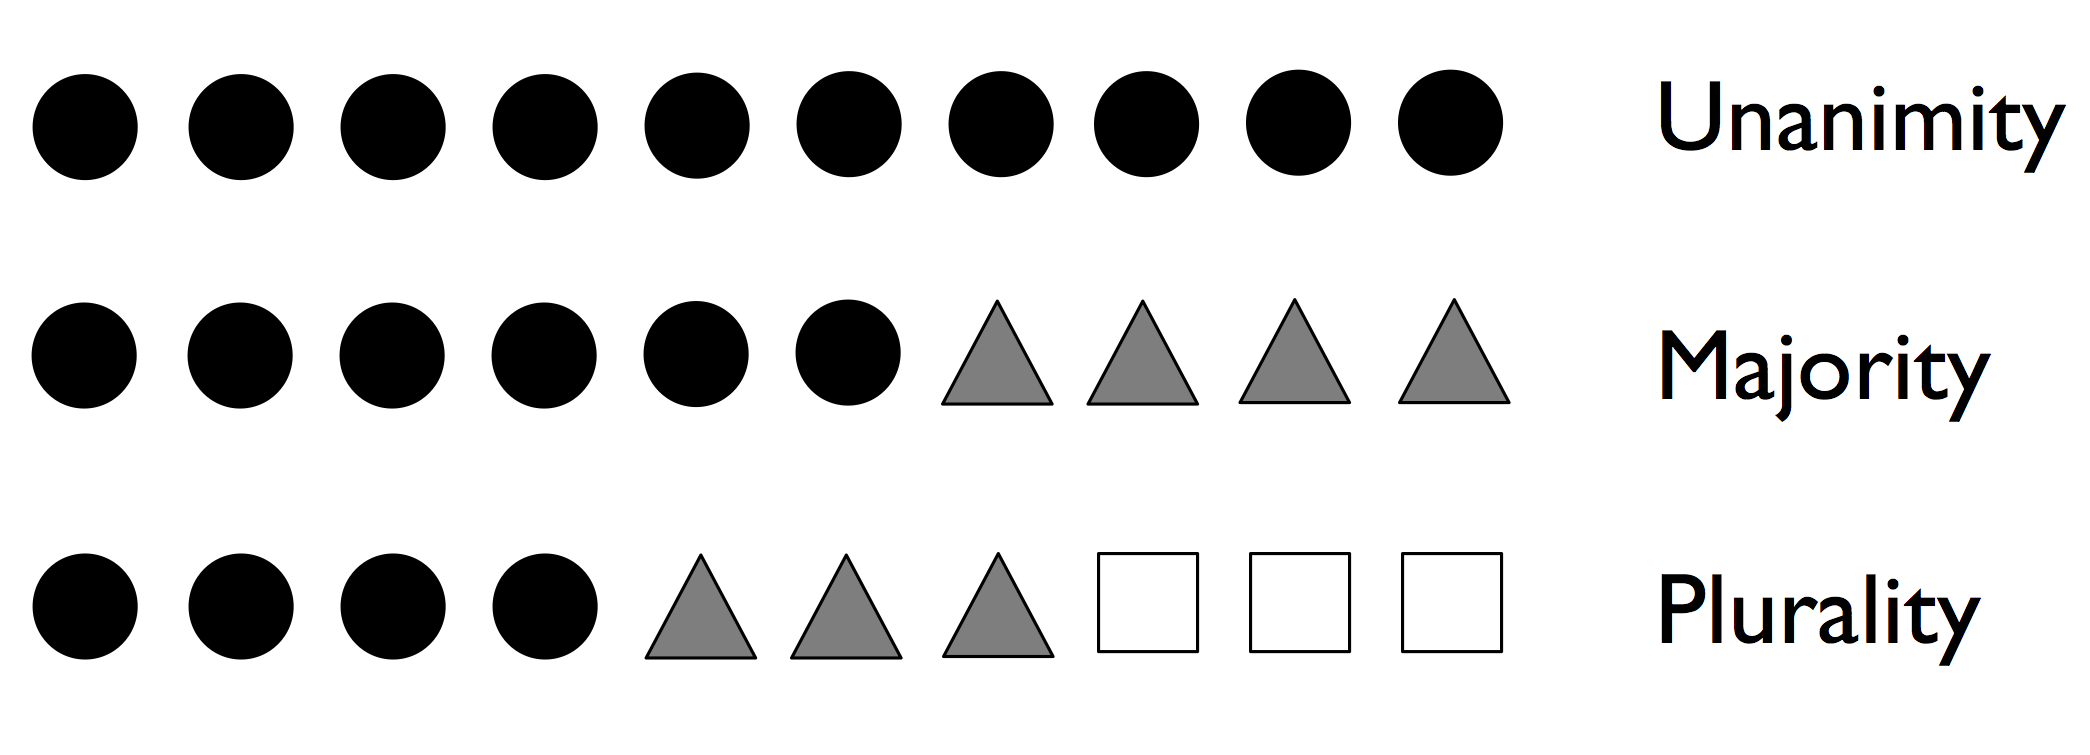

In [1]:
from IPython.display import Image

Image(filename='../Python-MachineLearning/Attached_images/Chapter7/figures/07_01.png', 
      width=450)

在上图中，可以看到有两个都代表多数的情况，"Majority"和"Plurality". 根据作者的注释，"In the UK, people distinguish between majority and plurality voting via the terms 'absolute' and 'relative' respectively." 也就是说，前者为绝对多数，后者为相对多数.

通常提到的多数投票集成方法如下图所示：

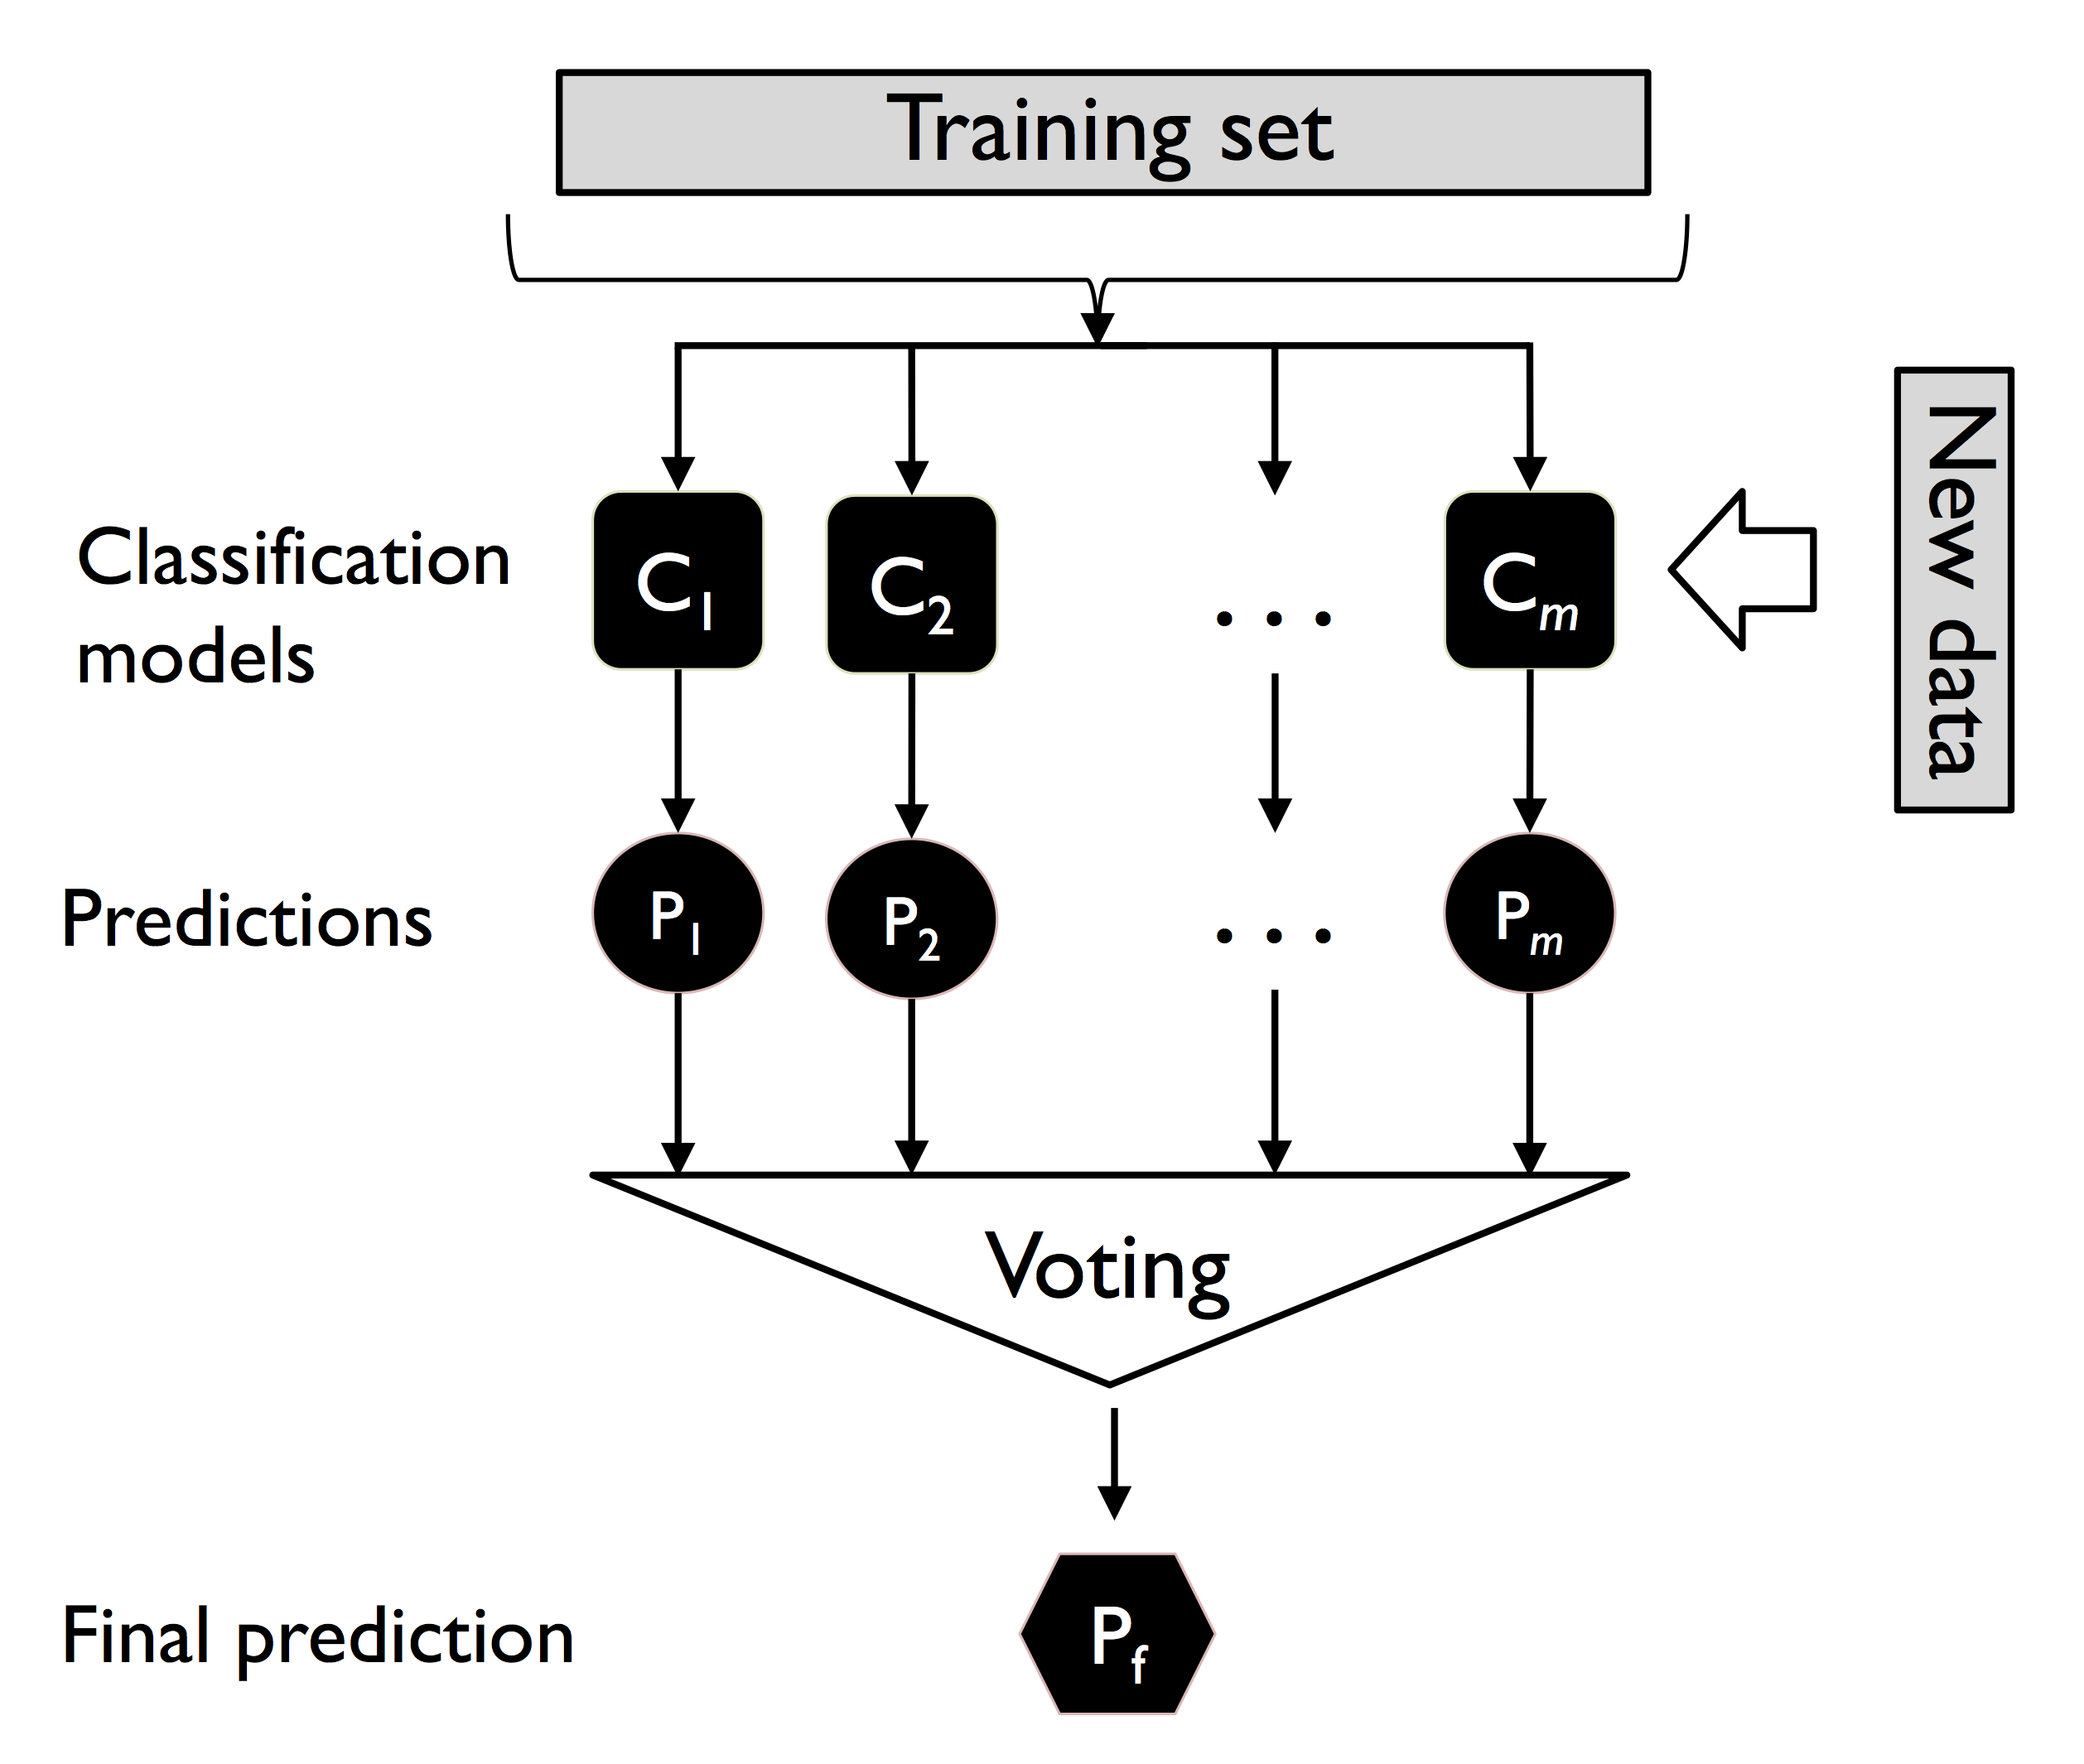

In [2]:
Image(filename='../Python-MachineLearning/Attached_images/Chapter7/figures/07_02.png', 
      width=450)

此时，对于单个的分类器$C_j$，利用多数投票法得到的预测标签$\hat{y}$可记录如下：

$$\hat{y}=\mathrm{mode}\{C_1(\boldsymbol{x}),C_2(\boldsymbol{x}),...,C_m(\boldsymbol{x})\}$$

在统计学中，`mode`代表的是一个集合中最频繁的事件或者结果。例如$\mathrm{mode}\{1,2,1,1,2,4,5,4\}=1$.

例如，在一个二分类任务中，class1= -1, class2= +1, 此时通过多数投票法集成学习预测过程如下：

$$C(\boldsymbol{x})=\operatorname{sign}\left[\sum_j^mC_j(\boldsymbol{x})\right]=
\begin{cases}
1&\text{if}\quad \sum_jC_j(\boldsymbol{x})\geq0\\
-1&\text{otherwise}
\end{cases}$$

在上式中，$\sum_jC_j(\boldsymbol{x})\geq0$就意味着个体分类器预测为+1的数量至少比预测为-1的数量多一个.

#### 假设说明

为说明集成方法为什么优于单独的学习器，这里做如下假设：

* 假设1：二分类任务的所有$n$个基分类器都具有相同的错误率$\varepsilon$;
* 假设2：所有的分类器彼此独立，且错误率不相关.

在上述假设下，可以将集成(ensemble)分类器的错误概率表示为如下概率质量函数(probability mass function):

$$
P(y\geq k)=\sum_k^n\binom{n}{k}\varepsilon^k(1-\varepsilon)^{n-k}=\varepsilon_\text{ensemble}
$$

在上式中，$y$是一个随机变量，$P(y\geq k)$表示至少有$k$个基学习器预测错误的概率，$\binom{n}{k}$是一个组合数，表示$n\quad choose \quad k$，也就是$n$个里面选$k$个.

示例，如果$n=11$, $\varepsilon=0.25$,则计算如下：

$$P(y\geq k)=\sum_{k=6}^{11}\binom{11}{k}0.25^k(1-0.25)^{11-k}=0.034$$

上述计算过程的Python实现如下：

In [3]:
import math

# 定义计算组合数的函数.
def combination(n, k):
    return math.factorial(n) // (math.factorial(k) * math.factorial(n - k))

# 定义计算概率的函数.
def calculate_probability(n, k, p):
    total_probability = 0
    for i in range(k, n + 1):
        total_probability += combination(n, i) * (p ** i) * ((1 - p) ** (n - i))
    return total_probability

# 给定的参数.
n = 11  # 基学习器的总数.
k = 6   # 基学习器数量.
p = 0.25  # 单个基学习器预测错误的概率.

# 计算集成模型错误概率.
probability = calculate_probability(n, k, p)
print(f"P(y >= {k}) = {probability}")

P(y >= 6) = 0.03432750701904297


In [4]:
# 如果是偶数(enen number)个分类器$n$.
import math

# 定义计算组合数的函数.
def combination(n, k):
    return math.factorial(n) // (math.factorial(k) * math.factorial(n - k))

# 定义计算概率的函数.
def calculate_probability(n, k, p):
    total_probability = 0
    for i in range(k, n + 1):
        total_probability += combination(n, i) * (p ** i) * ((1 - p) ** (n - i))
    return total_probability

# 给定的参数.
n = 12  # 基学习器的总数.
k = 6   # 基学习器数量.
p = 0.25  # 单个基学习器预测错误的概率.

# 计算集成模型错误概率.
probability = calculate_probability(n, k, p)
print(f"P(y >= {k}) = {probability}")

P(y >= 6) = 0.05440223217010498


In [5]:
# 利用scipy实现.
from scipy.special import comb
import math

def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.))
    probs = [comb(n_classifier, k) * error**k * (1-error)**(n_classifier-k)
        for k in range(k_start, n_classifier+1)]
    return sum(probs)

ensemble_error(n_classifier=11, error=0.25)

0.03432750701904297

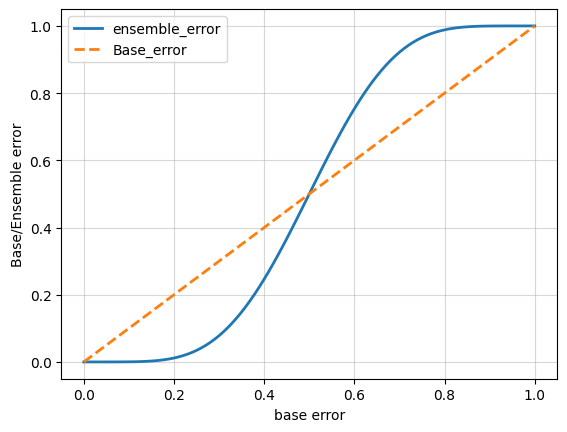

In [6]:
# 将基分类器误差定义为0.0到1.0的范围.
import numpy as np
import matplotlib.pyplot as plt

error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error) 
                for error in error_range]

plt.plot(error_range, ens_errors, 
         label='ensemble_error', 
         linewidth=2)

plt.plot(error_range, error_range, 
         linestyle='--', label='Base_error', linewidth=2)

plt.xlabel('base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()

从上图可以看出，集成学习器的误差总是比基分类器的误差小，前提是(基分类器的误差$\varepsilon < 0.5$).

#### 利用多数投票法实现分类器集成

实现一个简单的多数投票法分类器， 可以将加权多数投票法定义为如下形式：

$$\hat{y}=\arg\max_i\sum_{j=1}^mw_j\chi_A(C_j(\boldsymbol{x})=i)$$

在上式中，$w_j$是基分类器$C_j$的权重, $\hat{y}$是集成分类器的预测类别标签；$A$是特定的类别标签；$\chi_A$是一个指示函数，如果第$j$个分类器预测结果满足$C_j{\boldsymbol{x}=i}$,则返回1.

如果对基分类器赋予相同的权重，则上式可以写为如下形式：

$$\hat{y}=\mathrm{mode}\{C_1(\boldsymbol{x}),C_2(\boldsymbol{x}),...,C_m(\boldsymbol{x})\}$$

#### 一个计算示例

假设有三个基分类器$C_j(j\in\{1,2,3\})$，想要预测的类别标签$C_j{\boldsymbol(x)}\in\{0, 1\}$. 其中，有两个基分类器预测结果为0， 有一个预测结果为1(对应$C_3$).

* 情况1：如果对每个基分类器赋予相同的权重，则最终通过多数投票法预测得到的结果为0， 如下：

$$C_{1}(\boldsymbol{x})\to0,\quad C_{2}(\boldsymbol{x})\to0,\quad C_{3}(\boldsymbol{x})\to1
\\\hat{y}=\mathrm{mode}\{0,0,1\}=0$$

* 情况2：对$C_3$赋予0.6的权重， 同时让$C_1和C_2$权重都为$0.2$, 此时：

$$\begin{aligned}\widehat{y}&=\:\arg\max_i\sum_{j=1}^mw_j\chi_A\big(C_j(\boldsymbol{x})=i\big)\\&=\:\arg\max_i[0.2\times i_0+0.2\times i_0,0.6\times i_1]=1\end{aligned}$$

此时，我们可以说$C_3$做出的预测在最终预测结果中的话语权是$C_1,C_3$的3倍，所以这种情况下最终预测结果为第1类,即：

$$\hat{y}=\text{mode}\{0,0,1,1,1\}=1$$

In [7]:
# Python实现.

"""
使用Numpy找到一个数组中出现次数最多的
"""
import numpy as np

np.argmax(np.bincount([0, 0, 1], weights=[0.2, 0.2, 0.6]))

1

In [8]:
# 计算非负整数数组中每个整数值的出现次数的函数.
print(np.bincount([0, 0, 1]))

[2 1]


#### 使用类别预测的概率

在很多时候，仅预测得到一个类别标签无法满足实际需要，更理想的情况是得到一个概率值，此时集成分类器预测结果如下：
$$\hat{y}=\arg\max_i\sum_{j=1}^mw_jp_{ij}$$

其中，$p_{ij}$是第$j$个分类器预测结果为类别$i$的概率.

还是利用上述计算示例中的假设，此时三个分类器对给定样本$\boldsymbol{x}$的预测结果如下：

$$C_1(\boldsymbol{x})\to[0.9,0.1],\quad C_2(\boldsymbol{x})\to[0.8,0.2],\quad C_3(\boldsymbol{x})\to[0.4,0.6]$$

然后权重定义与上述示例相同，则：

$$p(i_0|\boldsymbol{x}) = 0.2\times0.9+0.2\times0.8+0.6\times0.4=0.58\\p(i_1|\boldsymbol{x}) = 0.2\times0.1+0.2\times0.2+0.6\times0.6=0.42\\\hat{y} = \arg\max_i[p(i_0|\boldsymbol{x}) ,p(i_1|\boldsymbol{x})]=0$$

In [9]:
# Python实现.
ex = np.array([[0.9, 0.1],
               [0.8, 0.2],
               [0.4, 0.6]])

p = np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])
p

array([0.58, 0.42])

In [10]:
np.argmax(p)

0

#### 利用Python实现MajorityVoteClassifier

In [11]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {
            key: value for key, value in _name_estimators(classifiers)
        }
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        if self.vote not in ('probability', 'classlabel'):
                raise ValueError(f"vote must be 'probability' or 'classlabel'"
                                f"; got (vote={self.vote})")

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError(f'Number of classifiers and weights must be equal'
                                f'; got {len(self.weights)} weights,'
                                f' {len(self.classifiers)} classifiers')
        
        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
        
    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Matrix of training examples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_examples]
            Predicted class labels.
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Training vectors, where n_examples is the number of examples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_examples, n_classes]
            Weighted average probability for each class per example.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super().get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out[f'{name}__{key}'] = value
            return out

#### 使用多数投票法进行预测

In [12]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
       train_test_split(X, y, 
                        test_size=0.5, 
                        random_state=1,
                        stratify=y)

In [13]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

clf1 = LogisticRegression(penalty='l2', 
                          C=0.001, 
                          solver='lbfgs', 
                          random_state=1)

clf2 = DecisionTreeClassifier(max_depth=1, 
                              criterion='entropy', 
                              random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=1, 
                            p=2, 
                            metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()], 
                 ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']

print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print(f'ROC AUC: {scores.mean():.2f} '
          f'(+/- {scores.std():.2f}) [{label}]')


10-fold cross validation:

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]


In [14]:
# 多数投票法集成.
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print(f'ROC AUC: {scores.mean():.2f} '
          f'(+/- {scores.std():.2f}) [{label}]')

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: 0.98 (+/- 0.05) [Majority voting]


#### 集成分类器评估和调参

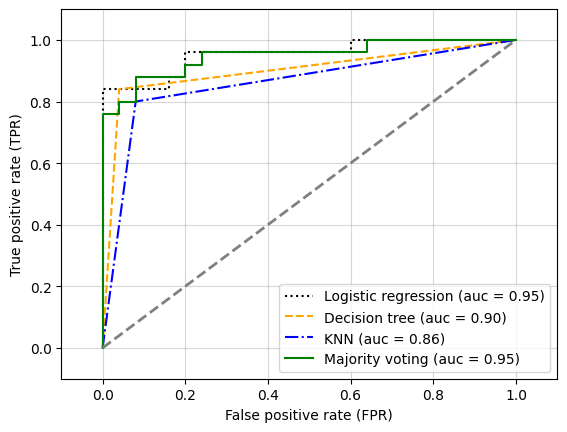

In [15]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls \
        in zip(all_clf,
               clf_labels, colors, linestyles):

    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train,
                     y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label=f'{label} (auc = {roc_auc:.2f})')

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()

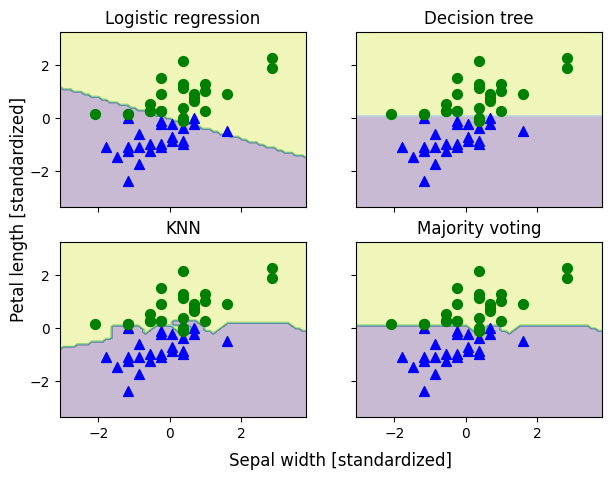

In [16]:
# 绘制决策边界.
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

from itertools import product


all_clf = [pipe1, clf2, pipe3, mv_clf]

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], 
                                  X_train_std[y_train==0, 1], 
                                  c='blue', 
                                  marker='^',
                                  s=50)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], 
                                  X_train_std[y_train==1, 1], 
                                  c='green', 
                                  marker='o',
                                  s=50)
    
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5., 
         s='Sepal width [standardized]', 
         ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5, 
         s='Petal length [standardized]', 
         ha='center', va='center', 
         fontsize=12, rotation=90)

plt.show()

In [17]:
# 调用get_params方法来看包含有哪些参数.
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1)]],
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf__max_iter': 100,
 'pipeline-1__clf__m

In [18]:
# 使用网格搜索进行参数调整.
from sklearn.model_selection import GridSearchCV

params = {'decisiontreeclassifier__max_depth': [1, 2], 
          'pipeline-1__clf__C':[0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=mv_clf, 
                    param_grid=params, 
                    cv=10, 
                    scoring='roc_auc')
grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                                                                           ['clf',
                                                                            LogisticRegression(C=0.001,
                                                                                               random_state=1)]]),
                                                           DecisionTreeClassifier(criterion='entropy',
                                                                                  max_depth=1,
                                                                                  random_state=0),
                                                           Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                                                                           ['clf',
                                                                            KNeighborsClassifier(n_neighbors=1)]])]),
             param_grid={'decisiontreeclassifier__max_depth': [1, 2],
                         'pipeline-1__clf__C': [0.001, 0.1, 100.0]},
             scoring='roc_auc')

In [19]:
# 打印不同的超参数组合和通过10折交叉验证计算的平均ROC、AUC.
for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    mean_score = grid.cv_results_['mean_test_score'][r]
    std_dev = grid.cv_results_['std_test_score'][r]
    params = grid.cv_results_['params'][r]
    print(f'{mean_score:.3f} +/- {std_dev:.2f} {params}')

0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.10 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.10 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [20]:
print(f'Best parameters: {grid.best_params_}')
print(f'ROC AUC: {grid.best_score_:.2f}')

Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
ROC AUC: 0.98


#### Bagging类集成学习

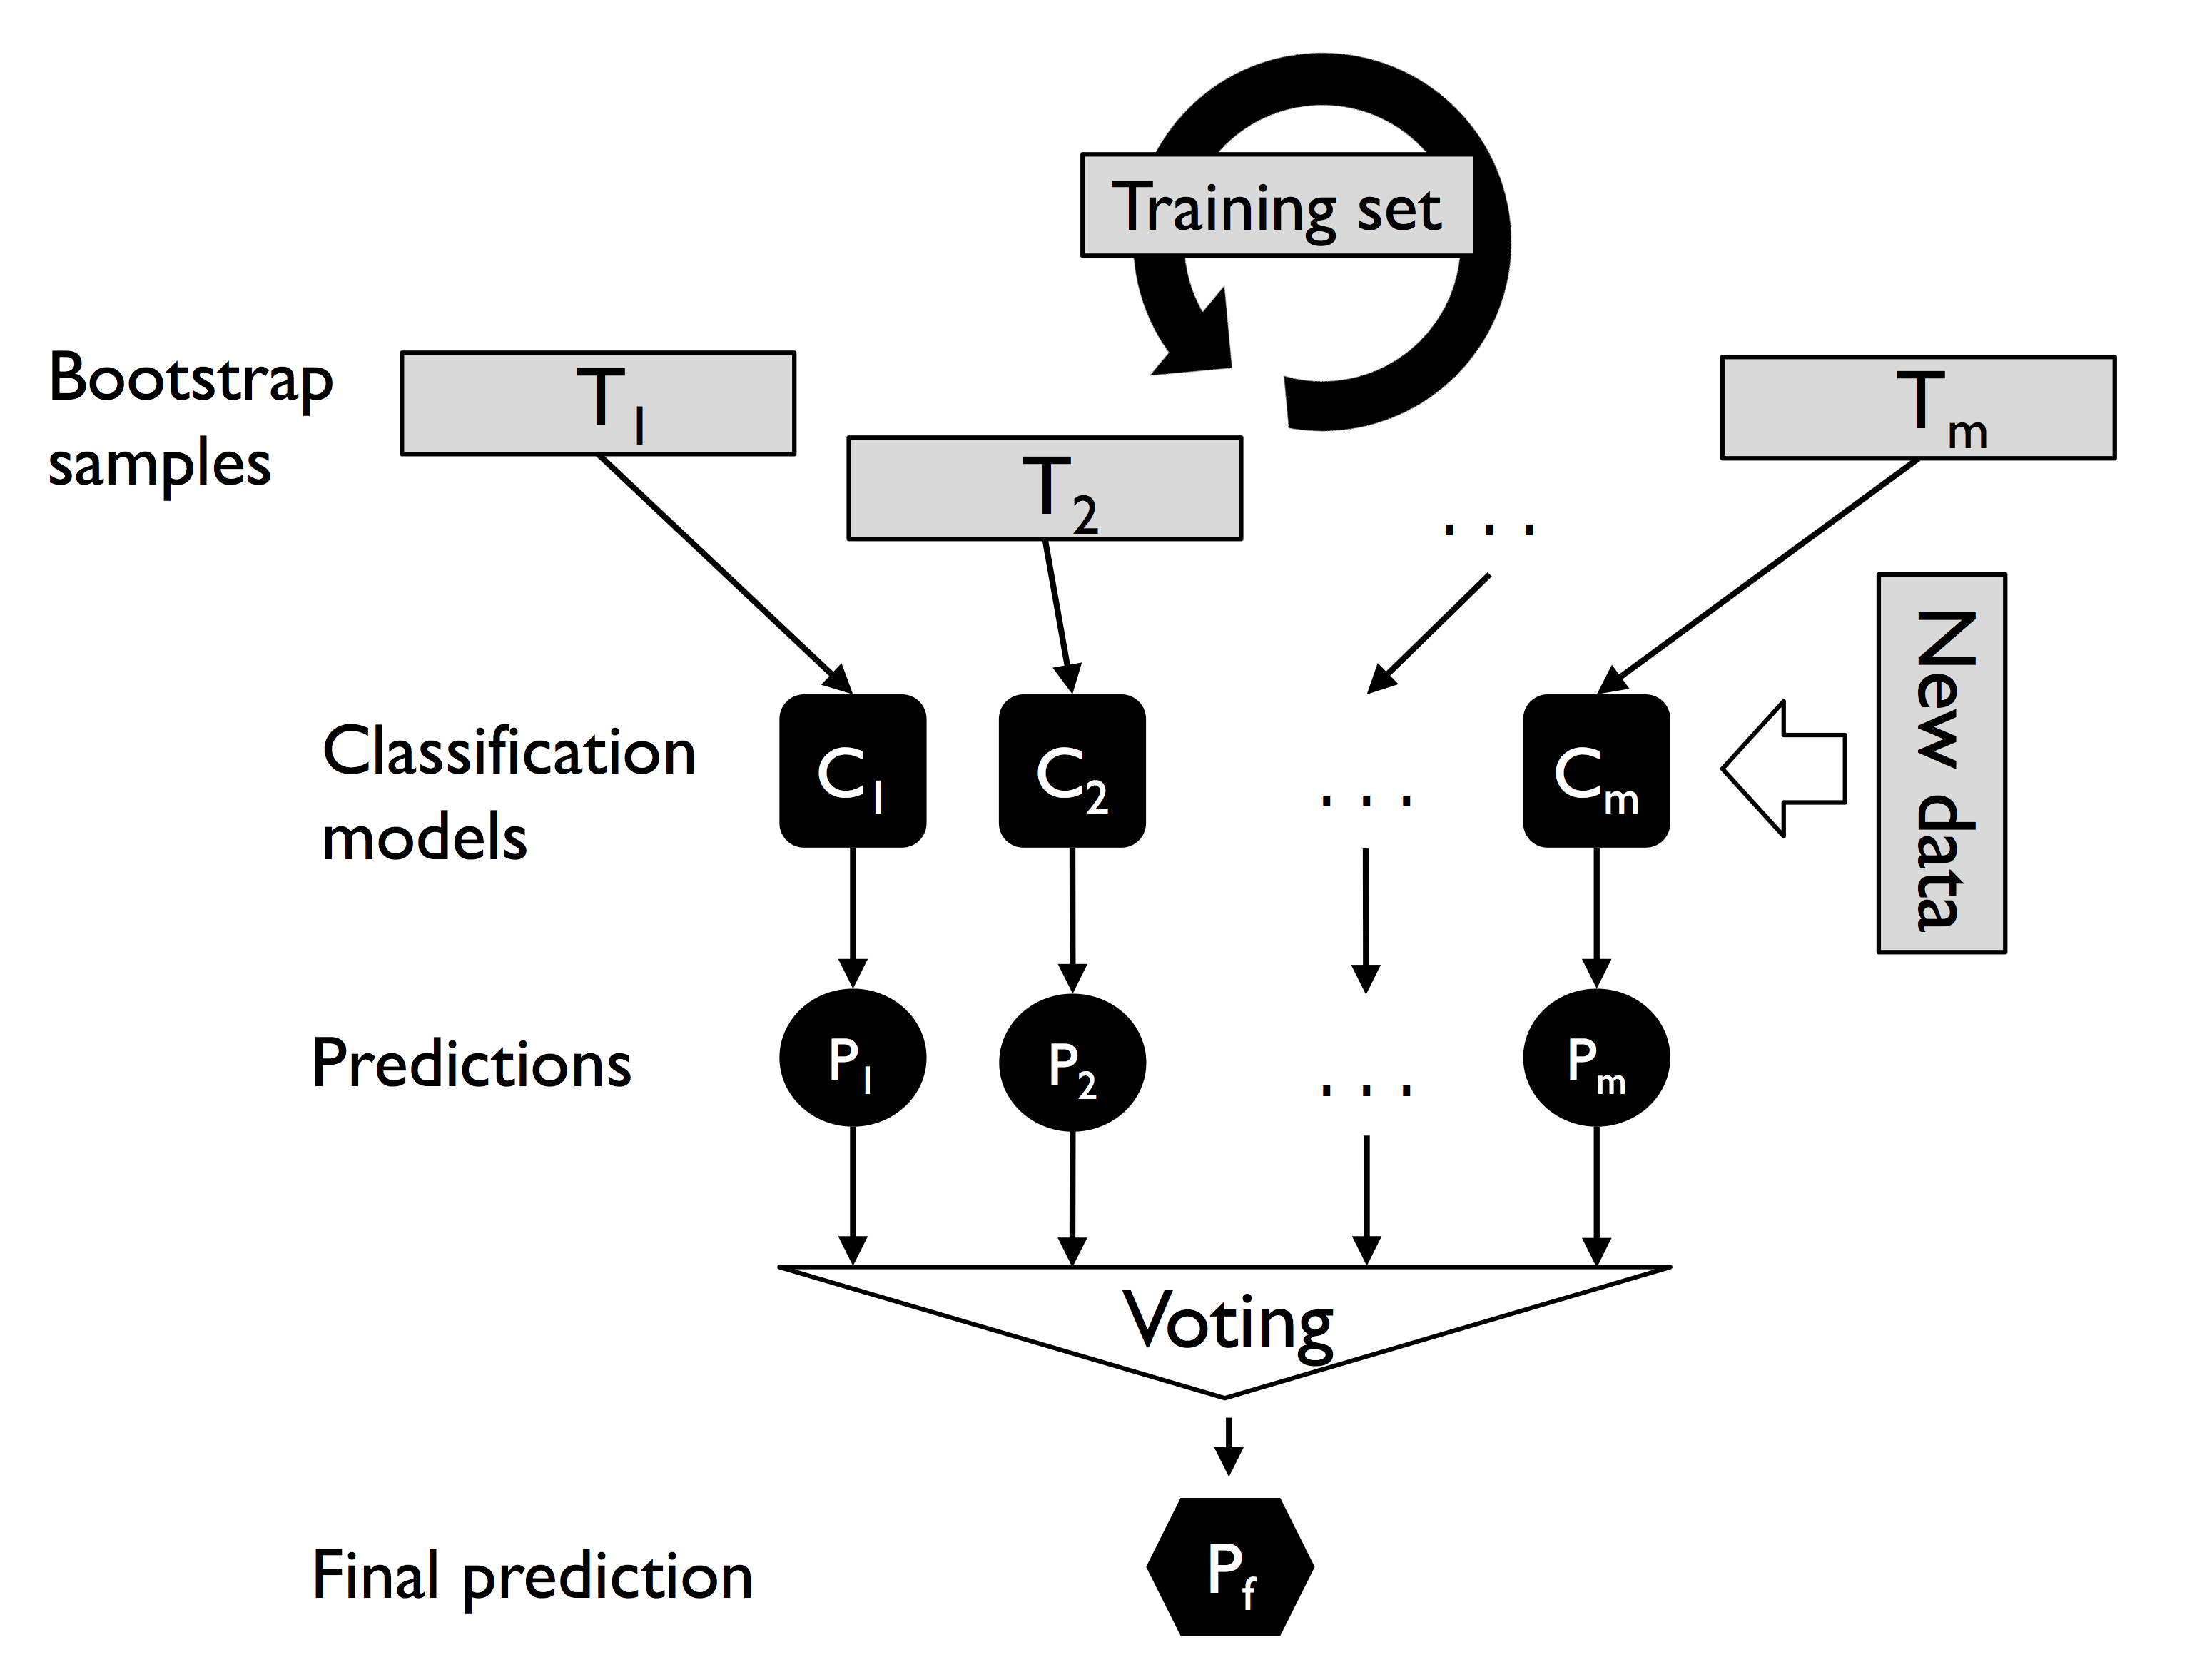

In [21]:
Image(filename='../Python-MachineLearning/Attached_images/Chapter7/figures/07_06.png', 
      width=450) 

##### Bagging简介

对于七个不同的训练样本，利用Bagging方法进行抽样并训练基学习器的过程如下：

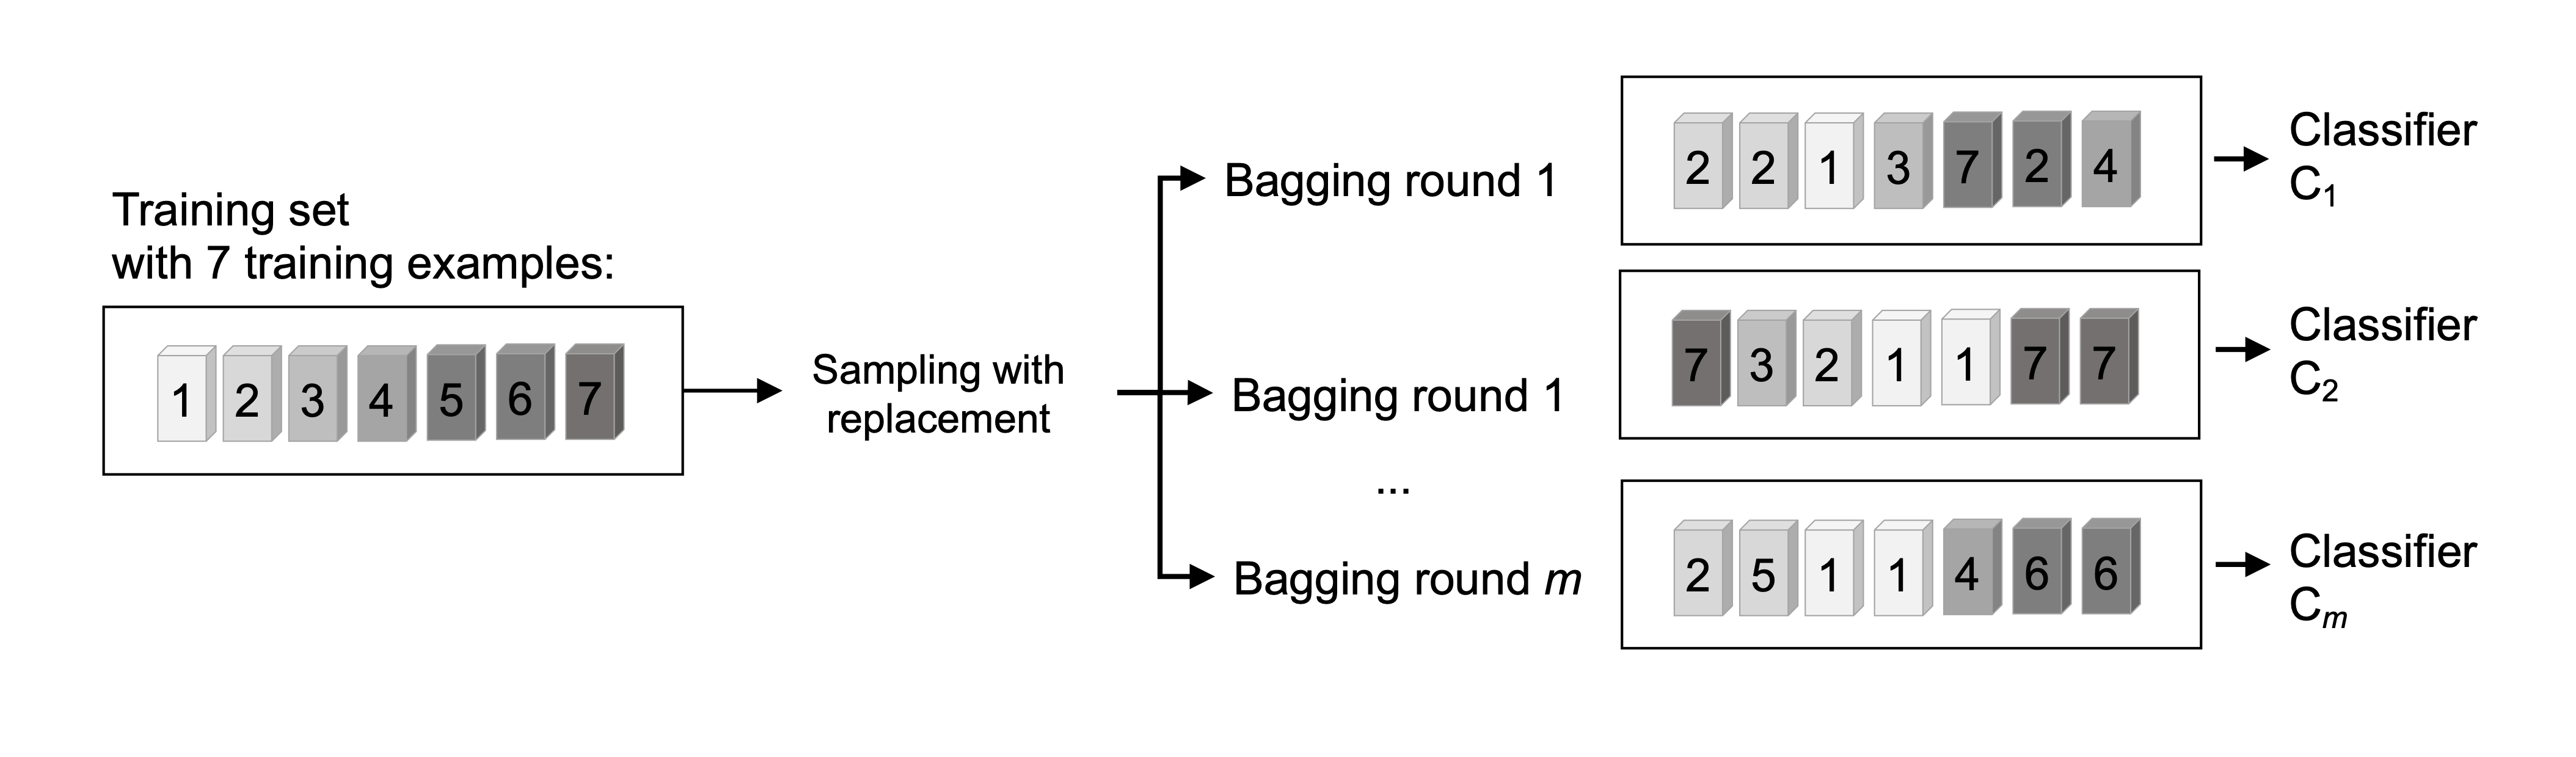

In [22]:
Image(filename='../Python-MachineLearning/Attached_images/Chapter7/figures/07_07.png', 
      width=550) 

##### 利用Bagging集成学习进行红酒数据分类

In [23]:
import pandas as pd


df_wine = pd.read_csv('../Python-MachineLearning/Datasets/Wine_data/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']


# drop 1 class, 仅使用类别2, 3.
df_wine = df_wine[df_wine['Class label'] != 1]

y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values

In [24]:
print(X.shape, y.shape)

(119, 2) (119,)


In [25]:
# 训练集和测试集划分.
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = \
            train_test_split(X, y, 
                             test_size=0.2, 
                             random_state=1, 
                             stratify=y)

In [26]:
# 使用sklearn实现Bagging.
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              random_state=1, 
                              max_depth=None)

bag = BaggingClassifier(estimator=tree, 
                        n_estimators=500, 
                        max_samples=1.0, 
                        max_features=1.0, 
                        bootstrap=True, 
                        bootstrap_features=False, 
                        n_jobs=-1, 
                        random_state=1)

In [27]:
# 计算评估指标.
from sklearn.metrics import accuracy_score

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)

print(f"Decision tree train/test accuracies"
      f'{tree_train: .3f}/{tree_test: .3f}')

Decision tree train/test accuracies 1.000/ 0.833


In [28]:
"""
从上面的结果中可以看出，未经过剪枝(unpruned decision tree)存在较大的方差，即出现了过拟合.
"""
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)

print(f"Baggign train/test accuracies"
      f'{bag_train:.3f}/{bag_test:.3f}')

Baggign train/test accuracies1.000/0.917


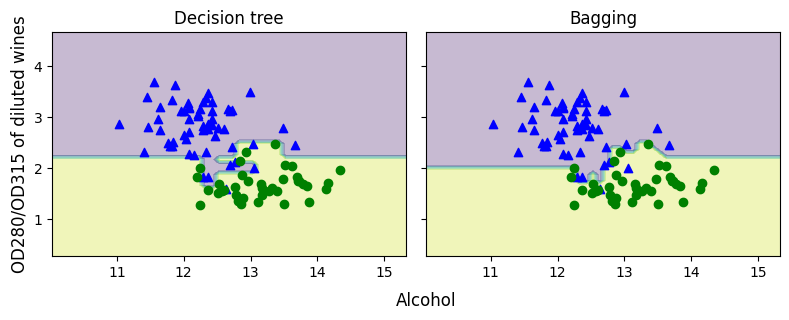

In [29]:
# 绘制决策树和Bagging的决策区域.
import numpy as np
import matplotlib.pyplot as plt


x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, bag],
                        ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')

    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')

    axarr[idx].set_title(tt)

axarr[0].set_ylabel('OD280/OD315 of diluted wines', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='Alcohol',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)

plt.show()

#### Boosting类集成学习

在Boosting中，基学习器通常被称为弱学习器. 其核心点是：专注于难以分类的训练示例.
这里主要聚焦在AdaBoost算法上. 

#### AdaBoost工作步骤

前面提到的Bagging类集成学习算法，主要是从原始数据集上进行有放回地采样，获取数据子集并训练多个基学习器.

与之不同的是，Boosting算法步骤可以总结如下：

* 从原始数据集$D$中无放回地，采样得到一个子集$d_1$, 并训练一个弱学习器$C_1$；
* 类似地，抽取第二个训练子集$d_2$, 并将前一个分类器错分样本的50%添加到数据集中，训练弱学习器$C_2$;
* 然后从数据集$D$中找到$C_1, C_2$预测结果不一致的训练样本集$d_3$, 来训练弱学习器$C_3$.
* 最后通过多数投票法将$C_1, C_2, C_3$的结果进行综合.

`与原始Boosting算法执行步骤不同的是`：
Adaboost使用完整的训练数据集来训练弱学习器，其中训练样本在每次迭代中被重写赋予权重，以构建一个强分类器，该分类器可以从集成模型中先前学习器错分样本中学习。AdaBoost的基本思想如下图所示：

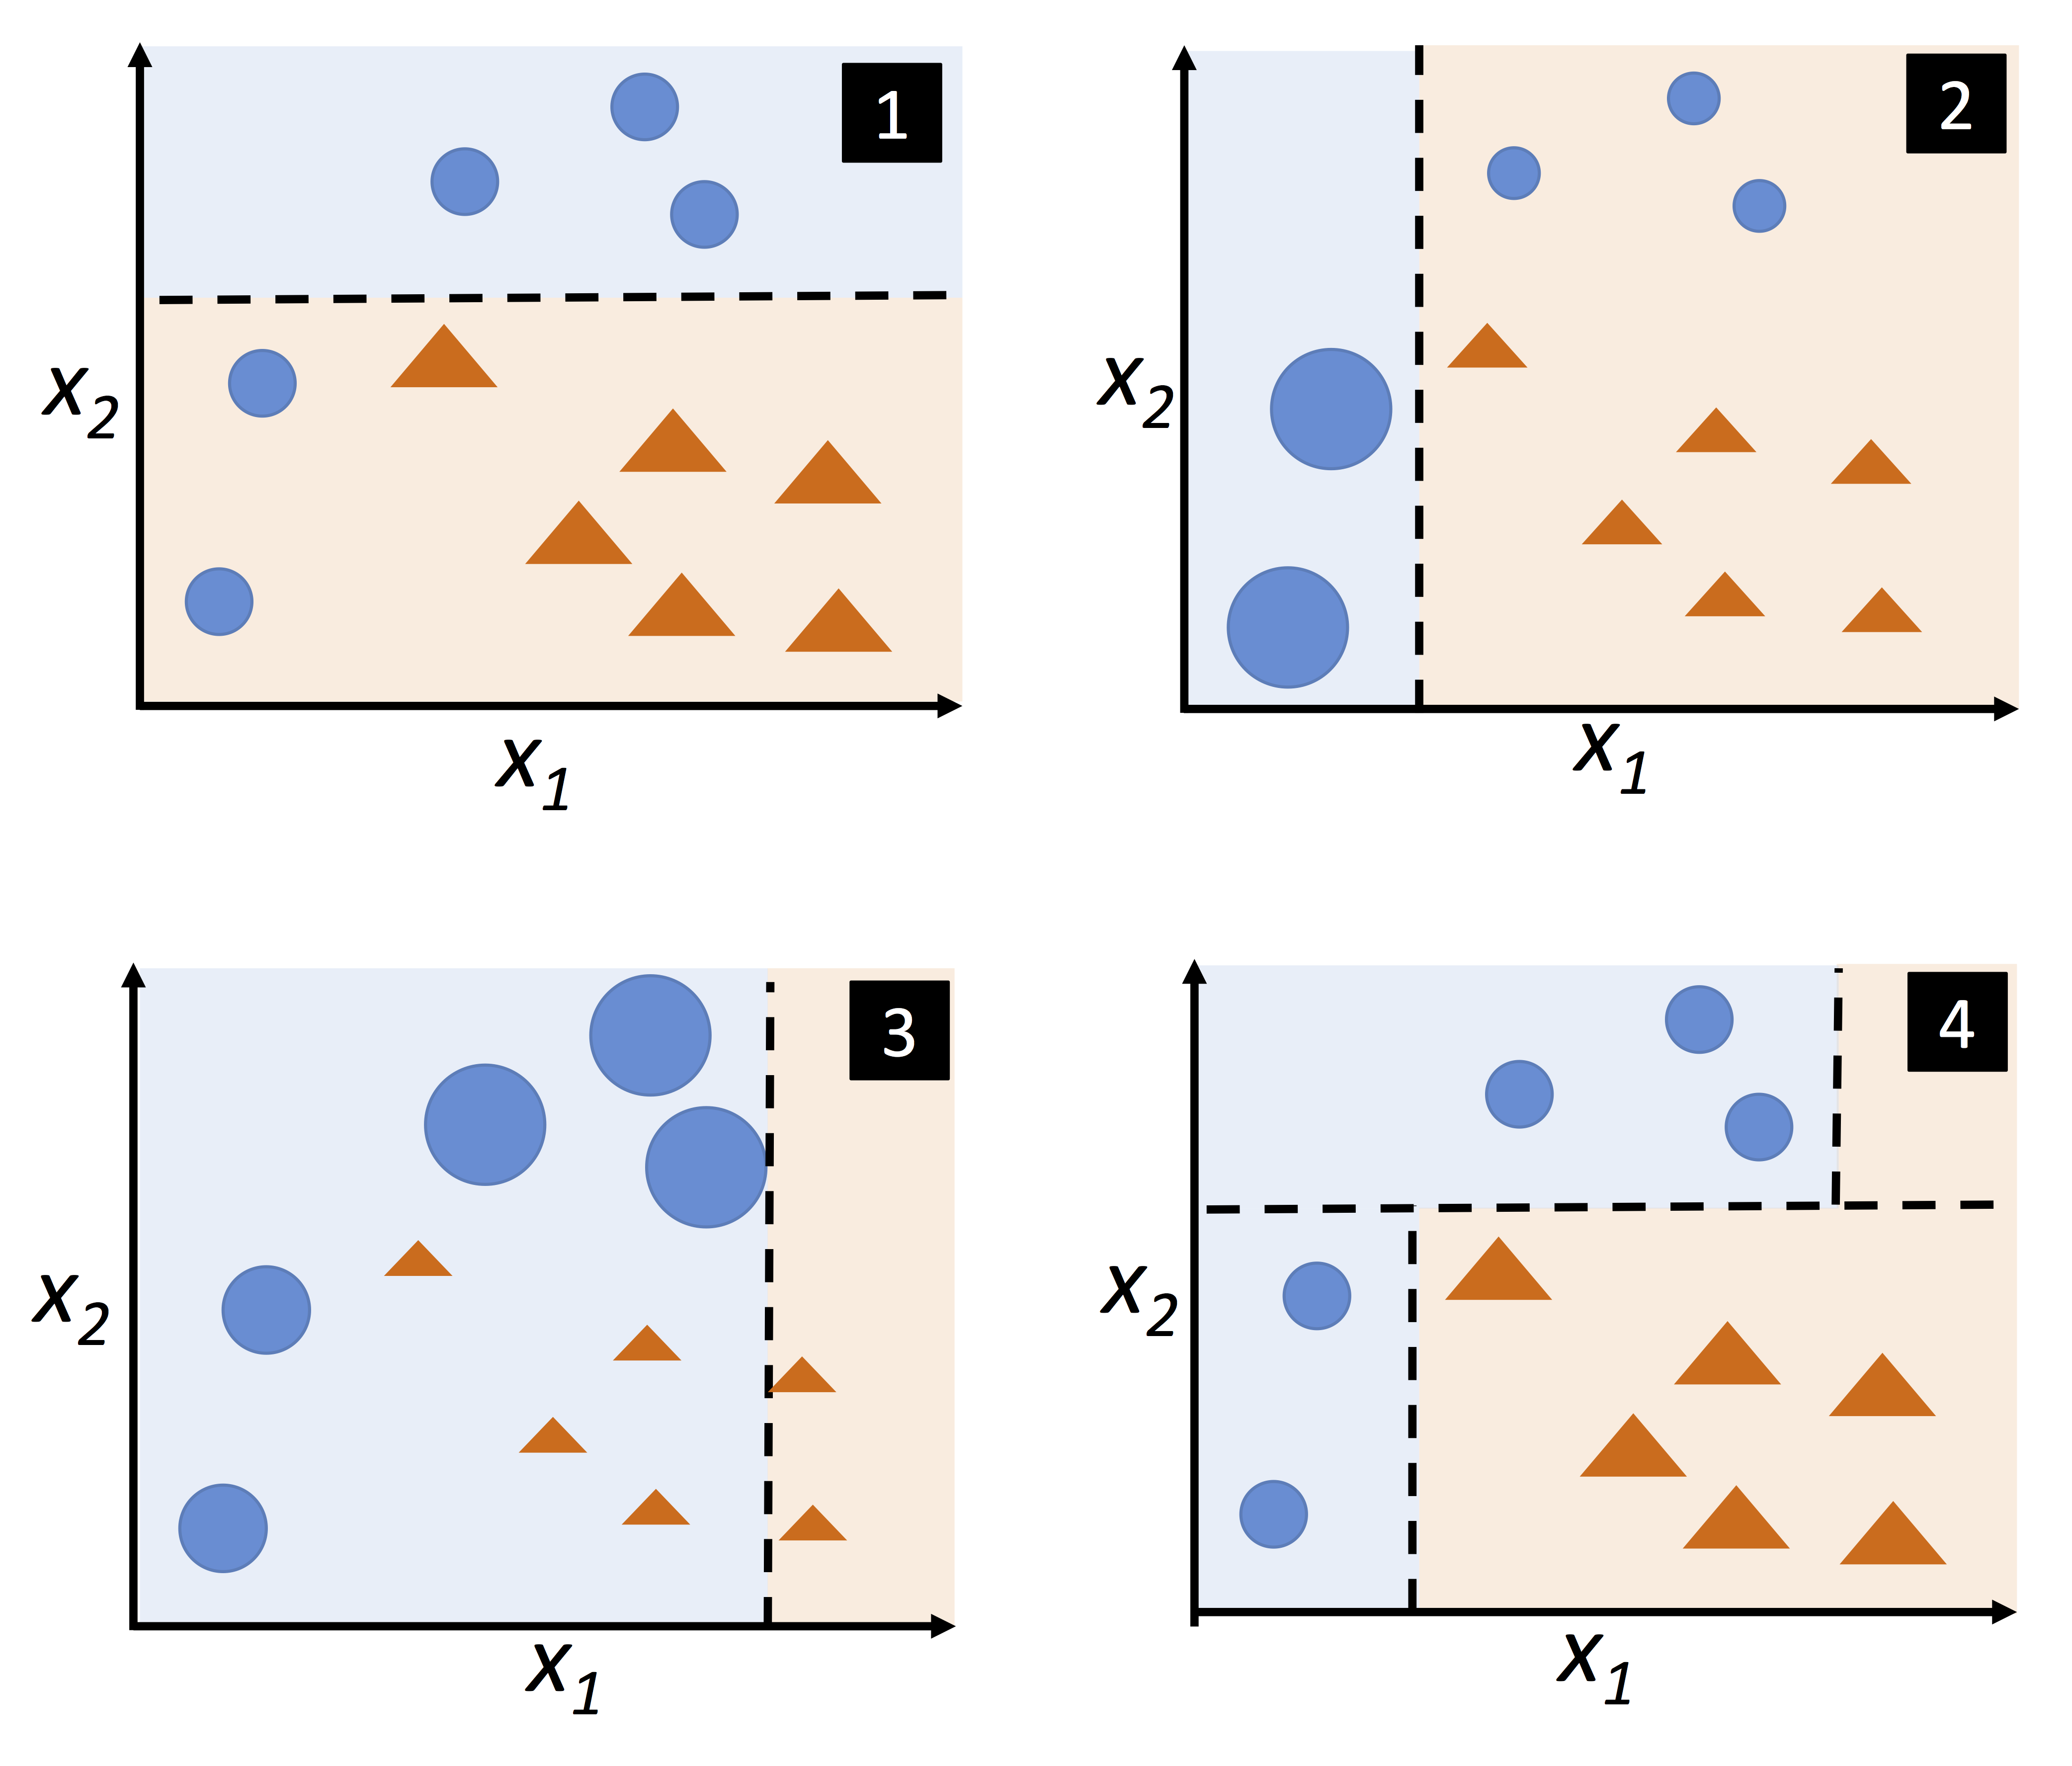

In [30]:
Image(filename='../Python-MachineLearning/Attached_images/Chapter7/figures/07_09.png', 
      width=450) 

#### AdaBoost伪代码

* Step1: 将权重向量$\boldsymbol{w}$设置为均匀权重，其中$\sum_i w_i=1$.
* Step2：循环，在$m$个Boosting轮回中，对于第$j$次boost，执行如下步骤：
    * a: 训练一个弱学习器: $C_j=train(\boldsymbol{X}, y, \boldsymbol{w})$.
    * b: 得到预测类别标签: $\widehat{y}=\mathrm{predict}(C_{j},\boldsymbol{X}).$
    * c: 计算加权错误率：$\varepsilon=\boldsymbol{w}\cdot(\widehat{\boldsymbol y}\neq \boldsymbol y).$
    * d: 计算系数： $\alpha_{j}=0.5\log\frac{1-\varepsilon}{\varepsilon}.$
    * e: 更新权重： $\boldsymbol{w}:=\boldsymbol{w}\times\exp(-\alpha_{j}\times\widehat{\boldsymbol{y}}\times\boldsymbol{y}).$
    * f: 对权重进行归一化： $\boldsymbol w:=\boldsymbol w/\sum_{i}\boldsymbol w_{i}.$
* Step3: 计算最终的预测结果： $ \widehat{\boldsymbol y}=(\sum_{j=1}^{m}(\alpha_{j}\times\mathrm{predict}(C_{j},\boldsymbol X))>0).$

在上式中，$\widehat{\boldsymbol y}\neq \boldsymbol y$是指由1和0组成的二进制向量.其中，如果预测错误，则赋值为1， 否则为0.

#### 一个计算示例

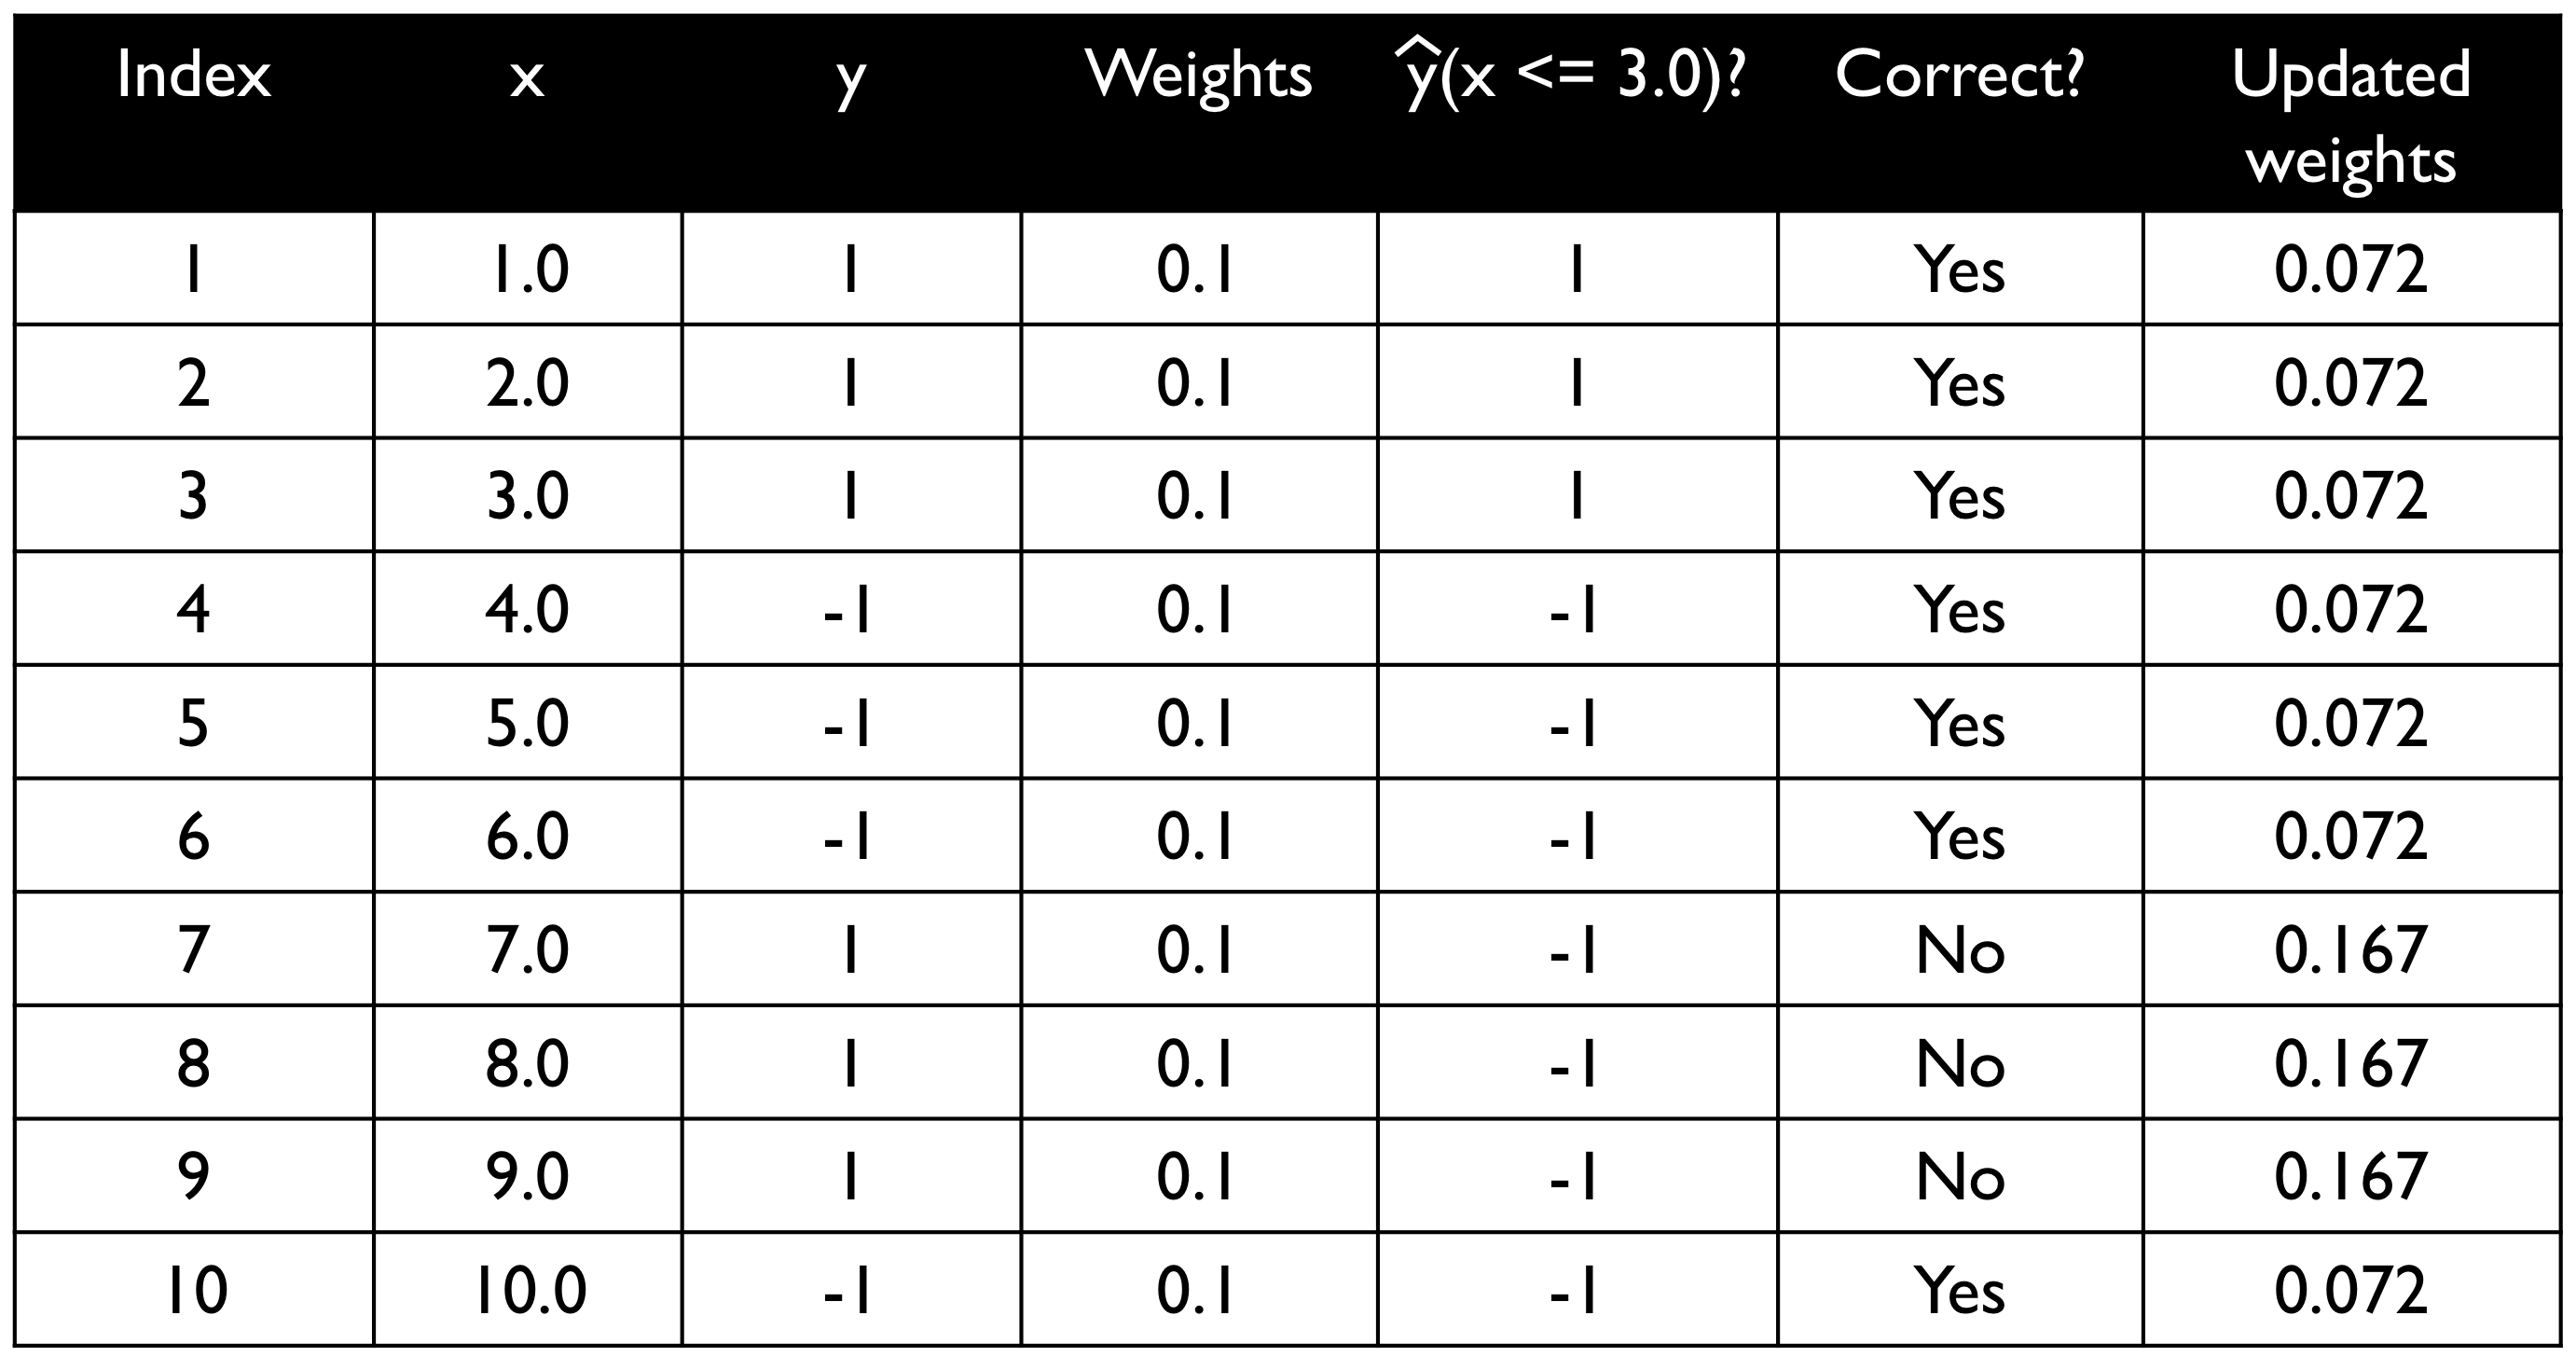

In [31]:
Image(filename='../Python-MachineLearning/Attached_images/Chapter7/figures/07_10.png', 
      width=450) 

In [32]:
# 首先计算加权误差率.
y = np.array([1, 1, 1, -1, -1, -1,  1,  1,  1, -1])
yhat = np.array([1, 1, 1, -1, -1, -1, -1, -1, -1, -1])

correct = (y == yhat)   # [ True  True  True  True  True  True False False False  True]
# print(correct)
weights = np.full(10, 0.1)  # [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
# print(weights)
epsilon = np.mean(~correct)
print(epsilon)

0.3


In [33]:
# 计算系数\alpha_j.
alpha_j = 0.5 * np.log((1-epsilon)/epsilon)
print(alpha_j)

0.42364893019360184


In [34]:
# 更新权重向量.
"""
预测得到的标签向量和真实标签向量进行元素级的乘法. 如果预测正确，则
二者乘积为正，则权重需要被降低.因为系数也为正.
"""
update_if_correct = 0.1 * np.exp(-alpha_j * 1 * 1)
print(update_if_correct)

0.06546536707079771


In [35]:
# 如果预测错误，则增加第i个权重.
update_if_wrong_1 = 0.1 * np.exp(-alpha_j * 1 * -1)
print(update_if_wrong_1)

0.1527525231651947


In [36]:
# 类似的，如果预测为-1，而真实为1.
update_if_wrong_2 = 0.1 * np.exp(-alpha_j * -1 * 1)
print(update_if_wrong_2)

0.1527525231651947


In [37]:
# 更新整个权重向量.
"""
关于np.where: It can be thought of as a vectorized way to perform conditional selection. 
"""
weights = np.where(correct == 1, 
                   update_if_correct, 
                   update_if_wrong_1)

print(weights)

[0.06546537 0.06546537 0.06546537 0.06546537 0.06546537 0.06546537
 0.15275252 0.15275252 0.15275252 0.06546537]


In [38]:
# 进行权重归一化.
normalized_weights = weights / np.sum(weights)
print(normalized_weights)

[0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.16666667 0.16666667 0.16666667 0.07142857]


#### 使用sklearn实现AdaBoost

In [39]:
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              random_state=1, 
                              max_depth=1)
ada = AdaBoostClassifier(estimator=tree, 
                         n_estimators=500, 
                         learning_rate=0.1, 
                         random_state=1)

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print(f'Decision tree train/test accuracies '
      f'{tree_train:.3f}/{tree_test:.3f}')

ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred) 
ada_test = accuracy_score(y_test, y_test_pred) 
print(f'AdaBoost train/test accuracies '
      f'{ada_train:.3f}/{ada_test:.3f}')

Decision tree train/test accuracies 0.916/0.875


d:\installation\Anaconda3\envs\pyml-book\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost train/test accuracies 1.000/0.917


d:\installation\Anaconda3\envs\pyml-book\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


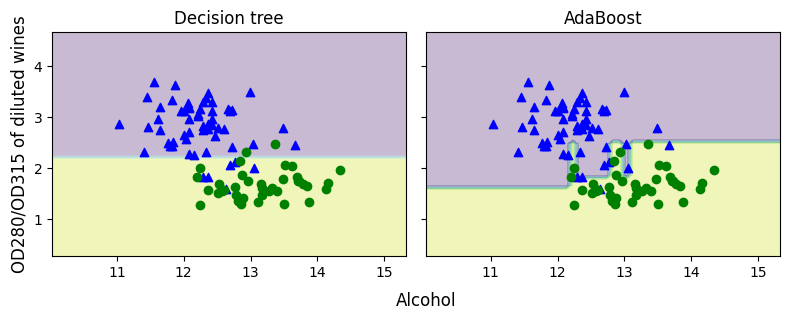

In [40]:
# 决策边界的对比.
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, ada],
                        ['Decision tree', 'AdaBoost']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('OD280/OD315 of diluted wines', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='Alcohol',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)

plt.show()

#### Gradient Boosting

##### [对比AdaBoost和Gradient Boosting](https://maelfabien.github.io/machinelearning/GradientBoost/#)

与Adaboost类似，Gradient Boosting也使用预测误差，并以迭代方式拟合决策树。然而，Gradient Boosting(梯度提升树)通常比决策树桩更深，此外与AdaBoost不同，梯度提升不使用预测误差来分配样本权重；相反，预测误差被直接用来建立目标变量以拟合下一棵树。此外，梯度提升不像AdaBoost那样为每棵树设置单独的权重项，而是使用对每棵树相同的全局学习率。

##### 梯度提升算法概述

本质上，梯度提升会构建一系列的树，其中每棵树都拟合前一棵树的误差(类别标签和预测值之间的差异)。在每一轮中，通过小幅度更新将每棵树推向正确的方向，集成树会得到提升。这些更新基于损失梯度，这就是梯度提升得名的原因。该算法的主要步骤如下：

* Step1: 初始化一个模型并返回常量预测值。为此，可以使用一个决策树根节点，即具有单个叶子节点的决策树。这里将树的返回值标记为$\hat{y}$, 并且通过最小化下面定义的损失函数来找到这个值：
$$F_0(x)=\arg\min_{\hat{y}}\sum_{i=1}^nL(y_i,\hat{y})$$
其中，$n$是数据集的样本数量.

* Step2: 对于每棵树$m=1,...,M$($M是用户指定的树的总棵树$)， 执行如下步骤：

    * a: 计算预测值与类别标签之间的差， 即$F(x_i)=\hat{y}_i与y_i之间的差别$. 这个值有时候被称为伪相应后伪残差(pseudo-response or pesudo-residual).更正式地说，可以将这个伪残差写成损失函数相对于预测值的负梯度：
        $$r_{im}=-\left[\frac{\partial L(y_{i},F(x_{i}))}{\partial F(x_{i})}\right]_{F(x) = F_{m-1}(x)}\quad\mathrm{for} \quad i=1,...,n$$
    其中，$F(x_i)$是前一棵树$F_{m-1}(x)$的预测结果。所以在第一轮中，它对应Step1中单个叶子结点树 预测得到的常量值。

    * b: 为伪残差$r_{im}$拟合一个树，以预测伪残差. 这里使用$R_{jm}$来表示第$m$次迭代中生成的树对应的$j=1...J_m$个叶子节点.
  
    * c: 对于每个叶子节点$R_{jm}$, 计算如下输出值：$$\gamma_{jm}=\arg\min_{\gamma}\sum_{x_i\in R_{jm}}L(y_i,F_{m-1}(x_i)+\gamma)$$
    * d: 通过将输出值$\gamma_{m}$添加到前一棵树来更新模型. $$F_m(x)=F_{m-1}(x)+\eta\gamma_m$$

#### 解释梯度提升分类算法

本小节将详细介绍如何实现二元分类的梯度提升算法. 对应的损失函数采用逻辑回归中的Logistic 损失函数， 如下：
$$L_i=-y_i\log p_i-(1-y_i)\log(1-p_i)$$
同时，前面介绍的log(odds)定义如下：
$$\hat{y}=\log(\mathrm{odds})=\log\left(\frac{p}{1-p}\right)$$

从上面公式可以得到：
$$p=\frac{e^{\hat{y}}}{1+e^{\hat{y}}}$$

所以代入到原损失函数，可以得到：
$$L_i=-y_i\log\left(\frac{e^{\hat{y}i}}{1+e^{\hat{y}_i}}\right)+(1-y_i)\log\left(1-\frac{e^{\hat{y}_i}}{1+e^{\hat{y}_i}}\right)$$

其中，$\log\left(\frac{e^{\hat{y}_i}}{1+e^{\hat{y}_i}}\right)=\hat{y}_i-\log(1+e^{\hat{y}_i})$， 同时有：
$$\begin{gathered}
1-p=1-\frac{e^{\hat{y}_{i}}}{1+e^{\hat{y}_{i}}}=\frac{1}{1+e^{\hat{y}_{i}}} \\
\text{然后}\log(1-p)\text{为}: \\
\log\left(\frac{1}{1+e^{\hat{y}_{i}}}\right)=-\log(1+e^{\hat{y}_{i}}) 
\end{gathered}$$

因此，$$L_i=-y_i\left(\hat{y}_i-\log(1+e^{\hat{y}_i})\right)-(1-y_i)(-\log(1+e^{\hat{y}_i}))\\ =-y_i\hat{y}_i+y_i\log(1+e^{\hat{y}_i})+(1-y_i)\log(1+e^{\hat{y}_i})=\color{red}-y_i\hat{y}_i+\log(1+e^{\hat{y}_i})$$

按照书上的推导，损失函数最终形式如下：

$$\color{blue}L_i=\log\bigl(1+e^{\hat{y}_i}\bigr)-y_i\hat{y}_i$$

因此，计算损失函数对于$\hat{y}$的偏导数如下：

$$\frac{\partial L_i}{\partial\hat{y}_i}=\frac{e^{\hat{y}_i}}{1+e^{\hat{y}_i}}-y_i=p_i-y_i$$

#### 结合二分类场景解释gradient boosting算法步骤

* Step1： 创建一个最小化逻辑损失的根节点. 所以根据上述推导，当根节点返回log(odds)，即$\hat{y}$的时候，损失最小.
* Step2: 对于每棵树$m=1, ..., M$, 这里的$M$是由人为指定的树的总棵树. 进一步执行如下步骤：

    * a: 将log(odds)转换为概率:$$p=\frac{1}{1+e^{-\hat{y}}}$$, 然后计算伪残差，它是类别标签与预测概率之间的差异：$$-\frac{\partial L_i}{\partial\hat{y}_i}=y_i-p_i$$
    * b: 拟合一棵树，去预测上述伪残差；
    * c: 对于每个叶子节点$R_{jm}$, 计算一个最小化逻辑损失函数的$\gamma_{jm}$， $$\gamma_{jm} = \arg\min_{\gamma}\sum_{x_{i}\in R_{jm}}L(y_{i},F_{m-1}(x_{i})+\gamma)\\= \log\bigl(1+e^{\hat{y}_{i}+\gamma}\bigr)-y_{i}(\hat{y}_{i}+\gamma)$$并进一步得到结果如下：$$\gamma_{jm}=\frac{\sum_iy_i-p_i}{\sum_ip_i(i-p_i)}$$其中，这里的加和 仅针对叶子节点$R_{jm}$对应节点上的示例，而不是完整的训练集.
    * d: 更新模型.$$F_{m}(x)=F_{m-1}(x)+\eta\gamma_{m}$$

#### 使用XGBoost

In [41]:
# %pip install -i https://pypi.tuna.tsinghua.edu.cn/simple xgboost

In [44]:
import xgboost as xgb

model = xgb.XGBClassifier(n_estimators=1000, 
                          learning_rate=0.01, 
                          max_depth=4, random_state=1, 
                          use_label_encoder=False)

gbm = model.fit(X_train, y_train)
y_train_pred = gbm.predict(X_train)
y_test_pred = gbm.predict(X_test)

gbm_train = accuracy_score(y_train, y_train_pred) 
gbm_test = accuracy_score(y_test, y_test_pred) 
print(f'XGboost train/test accuracies '
      f'{gbm_train:.3f}/{gbm_test:.3f}')

d:\installation\Anaconda3\envs\pyml-book\lib\site-packages\xgboost\core.py:158: UserWarning: [13:08:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGboost train/test accuracies 0.968/0.917
